# Create NLDI Site JSON
Date Updated: 08/22/2022

Steps to be taken...
- read in input files (created with SQL queries)
- clean & processes the Data...
- match the NLDI schema
- convert to geojson
- export outputs

In [1]:
# Needed Libararies

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt

pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook

C:\Users\rjame\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Setting work directory

cwd = os.getcwd()
Output = cwd
print("current directory = "+Output)

current directory = C:\Users\rjame\Documents\WSWC Documents\JupyterNotebooks\NLDI Sites for WestDAAT


## Input Data
- organizations
- sites

In [3]:
# organization input data and dataframe creation

fileInput = "rawdata/organization_raw.csv"
dforg = pd.read_csv(fileInput).replace(np.nan, "")
print(len(dforg))
dforg.head(1)

17


,State,OrganizationUUID
0,AZ,AZwr_O1


In [4]:
# Sites input data and dataframe creation

fileInput = "rawdata/sites_raw.csv"
df = pd.read_csv(fileInput).replace(np.nan, "")
print(len(df))
df.head(1)

2850100


,SiteUUID,Latitude,Longitude
0,AZwr_S1,0.0,-115.488744


## Clean & Processes the Data

In [5]:
# ensure lat and long values are numeric.  If not / if NaN, drop data.

# Temp fix
# Ensure long is < 0 and > -125 (few ID sites out of bounds)
# Ensure lat is > 10 and < 50 (few MT sites out of bounds).

df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

df = df[(df['Latitude'].astype(int) > 10) & (df['Latitude'].astype(int) < 50)]
df = df[(df['Longitude'].astype(int) < 0) & (df['Longitude'].astype(int) > -125)]

print(len(df))
df.head(1)

2648203


,SiteUUID,Latitude,Longitude
1,AZwr_S10,31.333972,-109.263389


In [6]:
# add State field

def createState(Val):
    Val = Val.strip()
    outString = Val[:2]
    return outString

df['State'] = df.apply(lambda row: createState(row['SiteUUID']), axis=1)
df['State'].unique()

array(['AZ', 'CA', 'CO', 'ID', 'KS', 'MT', 'ND', 'NE', 'NM', 'NV', 'OK',
       'OR', 'SD', 'TX', 'UT', 'WA', 'WY'], dtype=object)

In [7]:
# Left-Join Organization info

df = df.merge(dforg, on='State', how='left')
print(len(df))
df.head(1)

2648203


,SiteUUID,Latitude,Longitude,State,OrganizationUUID
0,AZwr_S10,31.333972,-109.263389,AZ,AZwr_O1


In [8]:
# add custom NLDI fields

df['GeoconnexAddress'] = "https://geoconnex.us/wade/sites/" + df['SiteUUID'].astype(str)
df['WaDELandingPageLink'] = "https://westdaat.westernstateswater.org/details/site/" + df['SiteUUID'].astype(str)
print(len(df))
df.head()

2648203


,SiteUUID,Latitude,Longitude,State,OrganizationUUID,GeoconnexAddress,WaDELandingPageLink
0,AZwr_S10,31.333972,-109.263389,AZ,AZwr_O1,https://geoconnex.us/wade/sites/AZwr_S10,https://westdaat.westernstateswater.org/detail...
1,AZwr_S100,31.346667,-110.200833,AZ,AZwr_O1,https://geoconnex.us/wade/sites/AZwr_S100,https://westdaat.westernstateswater.org/detail...
2,AZwr_S1000,31.530056,-111.020139,AZ,AZwr_O1,https://geoconnex.us/wade/sites/AZwr_S1000,https://westdaat.westernstateswater.org/detail...
3,AZwr_S10000,32.842778,-109.057778,AZ,AZwr_O1,https://geoconnex.us/wade/sites/AZwr_S10000,https://westdaat.westernstateswater.org/detail...
4,AZwr_S100000,34.060561,-113.174297,AZ,AZwr_O1,https://geoconnex.us/wade/sites/AZwr_S100000,https://westdaat.westernstateswater.org/detail...


<!-- ## Convert to geojson -->

## Match NLDI Schema
- match this sample 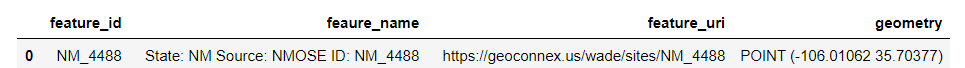

In [9]:
# create new dataframe.  match schmea from NLDI.
df2 = pd.DataFrame(columns=['feature_id', 'feature_name', 'feature_uri'], index=df.index)

df2['feature_id'] = df['SiteUUID']
df2['feature_name'] = "State: " + df['State'].astype(str) + " Source: " + df['OrganizationUUID'].astype(str) + " ID: " + df['SiteUUID'].astype(str)
df2['feature_uri'] = df['GeoconnexAddress']

print(len(df2))
df2.head()

2648203


,feature_id,feature_name,feature_uri
0,AZwr_S10,State: AZ Source: AZwr_O1 ID: AZwr_S10,https://geoconnex.us/wade/sites/AZwr_S10
1,AZwr_S100,State: AZ Source: AZwr_O1 ID: AZwr_S100,https://geoconnex.us/wade/sites/AZwr_S100
2,AZwr_S1000,State: AZ Source: AZwr_O1 ID: AZwr_S1000,https://geoconnex.us/wade/sites/AZwr_S1000
3,AZwr_S10000,State: AZ Source: AZwr_O1 ID: AZwr_S10000,https://geoconnex.us/wade/sites/AZwr_S10000
4,AZwr_S100000,State: AZ Source: AZwr_O1 ID: AZwr_S100000,https://geoconnex.us/wade/sites/AZwr_S100000


In [10]:
# convert dataframe to geodataframe

gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")
print(len(gdf2))
gdf2.head()

2648203


,feature_id,feature_name,feature_uri,geometry
0,AZwr_S10,State: AZ Source: AZwr_O1 ID: AZwr_S10,https://geoconnex.us/wade/sites/AZwr_S10,POINT (-109.26339 31.33397)
1,AZwr_S100,State: AZ Source: AZwr_O1 ID: AZwr_S100,https://geoconnex.us/wade/sites/AZwr_S100,POINT (-110.20083 31.34667)
2,AZwr_S1000,State: AZ Source: AZwr_O1 ID: AZwr_S1000,https://geoconnex.us/wade/sites/AZwr_S1000,POINT (-111.02014 31.53006)
3,AZwr_S10000,State: AZ Source: AZwr_O1 ID: AZwr_S10000,https://geoconnex.us/wade/sites/AZwr_S10000,POINT (-109.05778 32.84278)
4,AZwr_S100000,State: AZ Source: AZwr_O1 ID: AZwr_S100000,https://geoconnex.us/wade/sites/AZwr_S100000,POINT (-113.17430 34.06056)


## Check & Examine the resuling Data
- plot it out, look for oddities.

<AxesSubplot:>

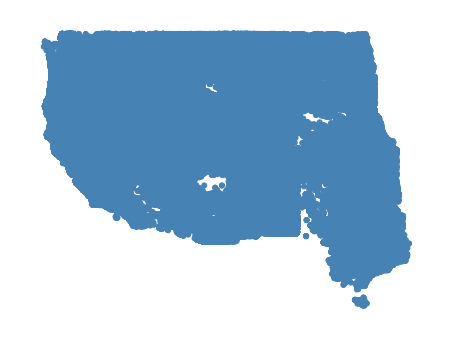

In [11]:
gplt.pointplot(gdf2)

## Exporting Files

In [12]:
# export geodataframe as geojson
df2.to_csv('outputs/wadeNLDISites.csv', index=False)
gdf2.to_file("outputs/wade.geojson", driver='GeoJSON')

C:\Users\rjame\anaconda3\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
